<a href="https://colab.research.google.com/github/p-p-p-p/precision-agriculture/blob/main/day1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
https://docs.google.com/document/d/1m4Vm_n3UK2XtNGOvMcR3J7VAtCRdI_lmrcTSeJNWGHA/edit?usp=sharing
https://www.kaggle.com/competitions/HyperLeaf2024
https://openaccess.thecvf.com/content/CVPR2024W/FGVC11/papers/Laprade_HyperLeaf2024_-_A_Hyperspectral_Imaging_Dataset_for_Classification_and_Regression_CVPRW_2024_paper.pdf

🧪 HyperLeaf2024 Dataset Analysis Notebook
We will structure this notebook into sections:

🔹 Table of Contents
1. Introduction
Setup & Dependencies
Load Train/Test Data
Visualize Hyperspectral Images
Analyze Targets (Regression & Classification)
Explore Spectral Profiles
Correlation Analysis Between Targets
Conclusion
Let’s begin.

📝 1. Introduction
This notebook provides an exploratory analysis of the HyperLeaf2024 dataset , a hyperspectral imaging dataset for wheat flag leaves used in classification and regression tasks. The dataset includes:

2410 hyperspectral images of wheat leaves.
Dimensions: 48 × 352 spatial × 204 spectral bands (400–1000 nm).
Targets:
Regression: GrainWeight, Gsw, PhiPS2, Fertilizer
Classification: Cultivar – Heerup, Kvium, Rembrandt, Sheriff
The goal is to understand patterns in the hyperspectral data and prepare for model training.



In [ ]:
#@title Download Dataset
!pip install -q kaggle
%cd /content
!rm -rf /content/kaggle.json
!gdown https://drive.google.com/uc?id=
!mkdir -p ~/.kaggle
!cp /content/kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c hyperleaf2024
!unzip /content/hyperleaf2024.zip -d hyperleaf2024
from IPython.display import clear_output
clear_output()


In [ ]:
#@title Install required libraries
# !pip install tifffile pandas numpy matplotlib seaborn scikit-learn spectral torch torchvision
!pip install spectral
!pip install rasterio
from IPython.display import clear_output
clear_output()


In [ ]:
#@title import
import os
import tifffile as tiff
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import spectral

In [ ]:
# Set up paths:
DATA_DIR = Path("/content/hyperleaf2024")
IMAGE_DIR = DATA_DIR / "images"
TRAIN_CSV = DATA_DIR / "train.csv"
TEST_CSV = DATA_DIR / "test.csv"


In [ ]:


# Load train CSV
train_df = pd.read_csv("hyperleaf2024/train.csv", dtype={"ImageId": str})
train_df["ImageId"] = train_df["ImageId"].astype(int).astype(str).str.zfill(5)

# Load test CSV
test_df = pd.read_csv("hyperleaf2024/test.csv", dtype={"ImageId": str})
test_df["ImageId"] = test_df["ImageId"].astype(int).astype(str).str.zfill(5)

print("Train DataFrame Shape:", train_df.shape)
print("Test DataFrame Shape:", test_df.shape)
train_df.head()

Train DataFrame Shape: (1590, 9)
Test DataFrame Shape: (820, 1)


,ImageId,GrainWeight,Gsw,PhiPS2,Fertilizer,Heerup,Kvium,Rembrandt,Sheriff
0,00000,4004,0.067527,0.627443,0.0,0,1,0,0
1,00001,6753,0.062773,0.664247,0.5,0,0,0,1
2,00003,8082,0.123482,0.425904,1.0,0,0,1,0
3,00007,8520,0.007312,0.691565,1.0,0,0,0,1
4,00009,8520,0.129374,0.502281,1.0,0,0,0,1


In [ ]:
train_df.describe()

,GrainWeight,Gsw,PhiPS2,Fertilizer,Heerup,Kvium,Rembrandt,Sheriff
count,1590.000000,1590.000000,1590.000000,1590.000000,1590.000000,1590.000000,1590.000000,1590.000000
mean,6355.477987,0.058049,0.553033,0.578616,0.257862,0.220126,0.270440,0.251572
std,2109.654578,0.030702,0.105888,0.467760,0.437595,0.414462,0.444327,0.434053
min,3100.000000,-0.009612,0.136364,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4220.000000,0.038092,0.466400,0.000000,0.000000,0.000000,0.000000,0.000000
50%,6591.000000,0.056796,0.536106,1.000000,0.000000,0.000000,0.000000,0.000000
75%,8193.000000,0.078823,0.662938,1.000000,1.000000,0.000000,1.000000,1.000000
max,9742.000000,0.157276,0.741180,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1590 entries, 0 to 1589
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ImageId      1590 non-null   object 
 1   GrainWeight  1590 non-null   int64  
 2   Gsw          1590 non-null   float64
 3   PhiPS2       1590 non-null   float64
 4   Fertilizer   1590 non-null   float64
 5   Heerup       1590 non-null   int64  
 6   Kvium        1590 non-null   int64  
 7   Rembrandt    1590 non-null   int64  
 8   Sheriff      1590 non-null   int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 111.9+ KB




### 🔍 Dataset Overview

This project uses the dataset provided in the [HyperLeaf 2024 competition](https://www.kaggle.com/competitions/HyperLeaf2024/overview), which focuses on predicting wheat cultivar traits using hyperspectral imaging.

---

#### 📁 Folder Structure

The dataset is organized as follows:

```
/content/hyperleaf2024
├── images/
│   ├── 00000.tiff
│   ├── 00001.tiff
│   └── ...
├── train.csv
├── test.csv
└── sample_submission.csv
```

* **`images/` folder:**
  Contains hyperspectral `.tiff` images of individual wheat leaves. Each image file name (e.g., `00000.tiff`) corresponds to an `ImageId` in the CSV files.

---

### 🧾 `train.csv` Structure

The `train.csv` file contains the ground truth labels for training. Each row corresponds to a wheat leaf sample, with the following columns:

| Column          | Description                                                                                                                          |
| --------------- | ------------------------------------------------------------------------------------------------------------------------------------ |
| **ImageId**     | The unique ID of the leaf image. It matches the filename in the `images/` folder (e.g., `02410.tiff` corresponds to `ImageId=2410`). |
| **GrainWeight** | Estimated weight of grains from the plant (continuous value).                                                                        |
| **Gsw**         | Grain-specific weight or density (continuous value).                                                                                 |
| **PhiPS2**      | A photosynthetic efficiency metric (ΦPSII), indicating light-use efficiency in the plant's photosystem II (continuous value).        |
| **Fertilizer**  | Amount of fertilizer applied to the plant during growth (continuous value).                                                          |
| **Heerup**      | One-hot encoded label: 1 if the sample belongs to the "Heerup" cultivar, else 0.                                                     |
| **Kvium**       | One-hot encoded label: 1 if the sample belongs to the "Kvium" cultivar, else 0.                                                      |
| **Rembrandt**   | One-hot encoded label: 1 if the sample belongs to the "Rembrandt" cultivar, else 0.                                                  |
| **Sheriff**     | One-hot encoded label: 1 if the sample belongs to the "Sheriff" cultivar, else 0.                                                    |

---

### 🎯 Prediction Targets

The task is to build a model that can predict **both regression and classification outputs** from hyperspectral images of leaves.

#### ✅ **Regression Targets:**

These are continuous variables you need to predict for each image:

* `GrainWeight`
* `Gsw`
* `PhiPS2`
* `Fertilizer`

#### ✅ **Classification Target:**

The cultivar of the leaf, encoded as four binary columns (`Heerup`, `Kvium`, `Rembrandt`, `Sheriff`). Only one of these columns will be `1` for each row — making it a **multi-class classification** problem, represented in **one-hot format**.

---

### 📌 Summary of the Task

* Input: Hyperspectral `.tiff` image (with hundreds of spectral bands per pixel).
* Output:

  * 4 continuous values (regression).
  * 1 class label from 4 possible cultivars (classification, represented as one-hot).

This makes the task a **multi-output supervised learning problem**, combining **regression** and **multi-class classification**.






## RGB Visualization from Hyperspectral Data (HyperLeaf2024)

I'm using the **HyperLeaf2024** dataset for my project. This dataset was captured using the **SpecimIQ hyperspectral camera**, which records 204 spectral bands from **400 nm to 1000 nm**.

### Step 1: Calculate Band Width

To find out the wavelength each band represents, we calculate the band spacing like this:

```

Band Width = (1000 nm - 400 nm) / 204 = 2.94 nm per band

```

So, each band represents about **2.94 nanometers**.

---

### Step 2: Map RGB Wavelengths to Band Numbers

We want to simulate an RGB image by selecting hyperspectral bands that are close to the red, green, and blue visible light wavelengths:

| Color | Wavelength | Calculation | Approx Band Number |
|-------|------------|-------------|---------------------|
| Blue  | 470 nm     | (470 - 400) / 2.94 ≈ 24  | 24  |
| Green | 550 nm     | (550 - 400) / 2.94 ≈ 51  | 51  |
| Red   | 660 nm     | (660 - 400) / 2.94 ≈ 88  | 88  |

---

### Step 3: Use These Bands to Create RGB

To visualize an RGB image:
- Use **Band 88** for Red
- Use **Band 51** for Green
- Use **Band 24** for Blue

This helps turn the grayscale hyperspectral data into a rough RGB image for better visual analysis.


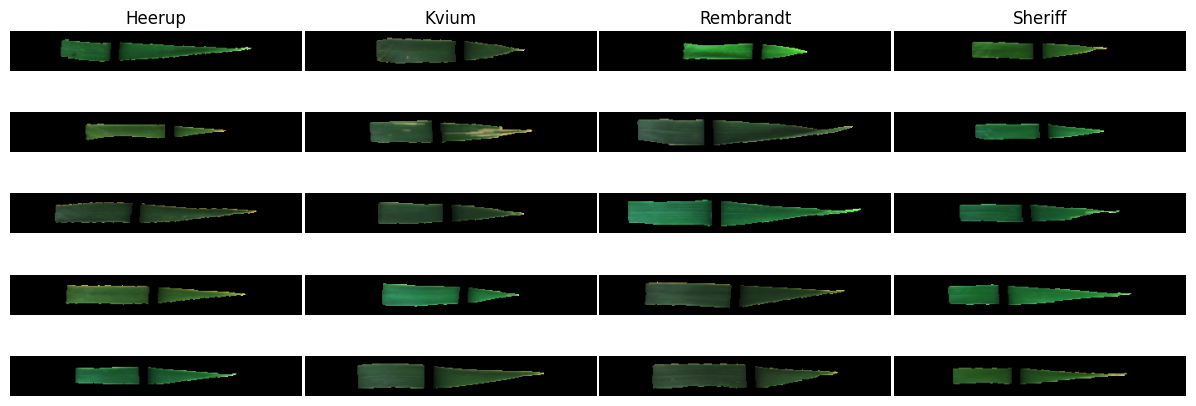

In [ ]:
#@title 5 Samples from Each Wheat Cultivar (RGB from Hyperspectral)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile as tiff

# For Jupyter Notebook or Colab
%matplotlib inline

# Function to extract RGB from hyperspectral .tiff image
def tiff_to_rgb(tiff_path):
    cube = tiff.imread(tiff_path)
    blue_band = 24   # ~470 nm
    green_band = 51  # ~550 nm
    red_band = 88    # ~660 nm

    rgb = np.stack([
        cube[red_band],
        cube[green_band],
        cube[blue_band],
    ], axis=-1)

    rgb = rgb.astype(np.float32)
    rgb -= rgb.min()
    rgb /= rgb.max()

    return rgb

# Paths
data_dir = '/content/hyperleaf2024'
img_dir = os.path.join(data_dir, 'images')
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))

# Cultivars to show
cultivars = ['Heerup', 'Kvium', 'Rembrandt', 'Sheriff']
samples_per_class = 5

# Sample 5 images per cultivar
sampled_images = {
    cultivar: train_df[train_df[cultivar] == 1].sample(samples_per_class, random_state=42)['ImageId'].values
    for cultivar in cultivars
}

# Plot
fig, axes = plt.subplots(nrows=samples_per_class, ncols=len(cultivars), figsize=(12, 7),
                         gridspec_kw={'wspace': 0.01, 'hspace': 0.01})

for col, cultivar in enumerate(cultivars):
    for row in range(samples_per_class):
        img_id = str(sampled_images[cultivar][row]).zfill(5)
        img_path = os.path.join(img_dir, f"{img_id}.tiff")
        ax = axes[row, col]
        ax.axis('off')

        if os.path.exists(img_path):
            rgb_img = tiff_to_rgb(img_path)
            ax.imshow(rgb_img)

# Add column headers (cultivar names)
for col, cultivar in enumerate(cultivars):
    axes[0, col].set_title(cultivar, fontsize=12, pad=5)

# Set overall title, reduce vertical space
# fig.suptitle("5 Samples from Each Wheat Cultivar (RGB from Hyperspectral)", fontsize=16, y=0.93)
plt.subplots_adjust(top=0.60, bottom=0.02, left=0.01, right=0.99)
plt.show()


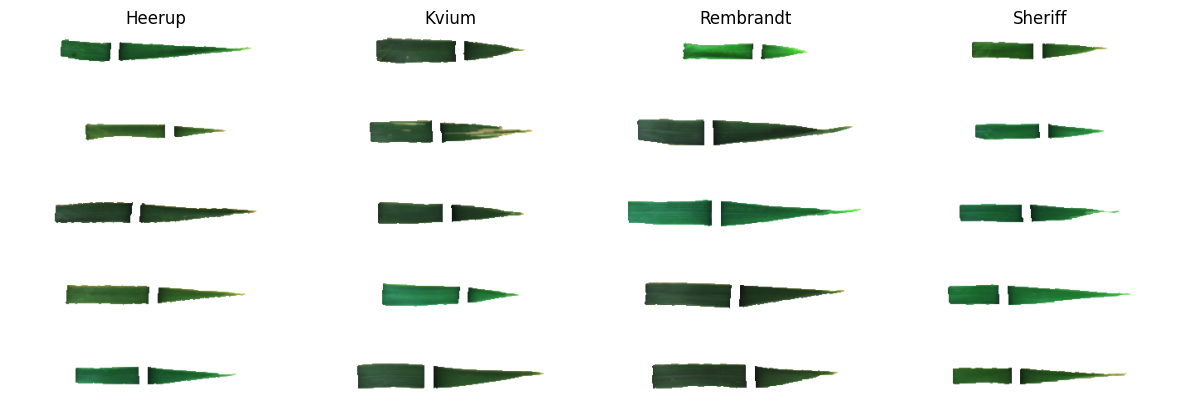

In [ ]:
#@title 5 Samples from Each Wheat Cultivar (RGB from Hyperspectral with Background Removed)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile as tiff

# For Jupyter Notebook or Colab
%matplotlib inline

# Function to extract RGB and remove dark background
def tiff_to_rgb_background_remove(tiff_path, background_threshold=0.05):
    cube = tiff.imread(tiff_path)

    # Approximate visible light bands
    blue_band = 24   # ~470 nm
    green_band = 51  # ~550 nm
    red_band = 88    # ~660 nm

    # Stack into RGB
    rgb = np.stack([cube[red_band], cube[green_band], cube[blue_band]], axis=-1)

    # Normalize
    rgb = rgb.astype(np.float32)
    rgb -= rgb.min()
    rgb /= rgb.max()

    # Create background mask
    background_mask = np.all(rgb <= background_threshold, axis=-1)

    # Replace dark background with white
    rgb[background_mask] = [1.0, 1.0, 1.0]

    return rgb

# Paths
data_dir = '/content/hyperleaf2024'
img_dir = os.path.join(data_dir, 'images')
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))

# Cultivars to show
cultivars = ['Heerup', 'Kvium', 'Rembrandt', 'Sheriff']
samples_per_class = 5

# Sample 5 images per cultivar
sampled_images = {
    cultivar: train_df[train_df[cultivar] == 1].sample(samples_per_class, random_state=42)['ImageId'].values
    for cultivar in cultivars
}

# Plot
fig, axes = plt.subplots(nrows=samples_per_class, ncols=len(cultivars), figsize=(12, 7),
                         gridspec_kw={'wspace': 0.01, 'hspace': 0.01})

for col, cultivar in enumerate(cultivars):
    for row in range(samples_per_class):
        img_id = str(sampled_images[cultivar][row]).zfill(5)
        img_path = os.path.join(img_dir, f"{img_id}.tiff")
        ax = axes[row, col]
        ax.axis('off')

        if os.path.exists(img_path):
            rgb_img = tiff_to_rgb_background_remove(img_path)
            ax.imshow(rgb_img)
        else:
            ax.text(0.5, 0.5, "Missing", ha='center', va='center', color='red')

# Add column headers (cultivar names)
for col, cultivar in enumerate(cultivars):
    axes[0, col].set_title(cultivar, fontsize=12, pad=5)

# plt.suptitle("5 Samples from Each Wheat Cultivar (RGB with Background Removed)", fontsize=16, y=0.92)
plt.subplots_adjust(top=0.60, bottom=0.02, left=0.01, right=0.99)
plt.show()


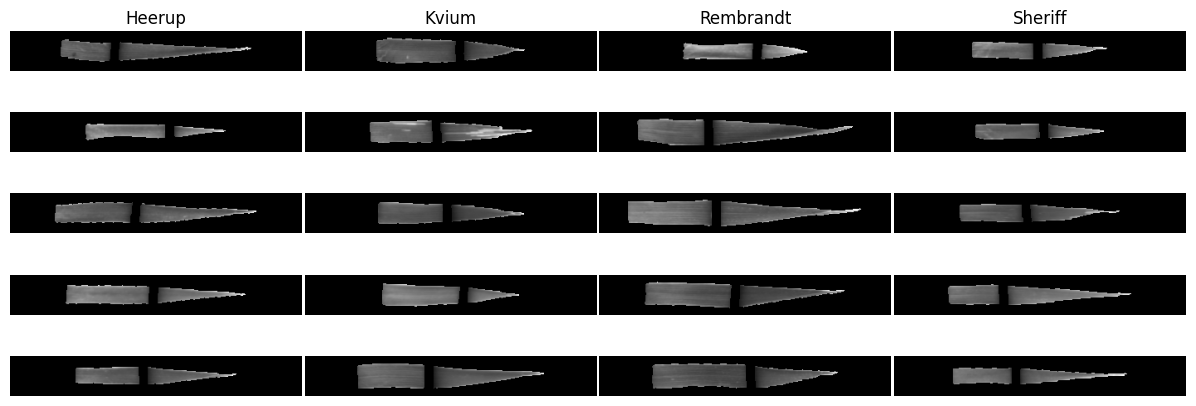

In [ ]:
#@title 5 Samples from Each Wheat Cultivar (Original Hyperspectral Band 50)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tifffile as tiff

%matplotlib inline

# Function to read one band (grayscale view)
def load_single_band(tiff_path, band=50):  # Mid-range band
    cube = tiff.imread(tiff_path)
    image = cube[band]
    image = image.astype(np.float32)
    image -= image.min()
    image /= image.max()
    return image

# Paths
data_dir = '/content/hyperleaf2024'
img_dir = os.path.join(data_dir, 'images')
train_df = pd.read_csv(os.path.join(data_dir, 'train.csv'))

# Cultivars
cultivars = ['Heerup', 'Kvium', 'Rembrandt', 'Sheriff']
samples_per_class = 5

# Sample 5 images per cultivar
sampled_images = {
    cultivar: train_df[train_df[cultivar] == 1].sample(samples_per_class, random_state=42)['ImageId'].values
    for cultivar in cultivars
}

# Plot
fig, axes = plt.subplots(nrows=samples_per_class, ncols=len(cultivars), figsize=(12, 7),
                         gridspec_kw={'wspace': 0.01, 'hspace': 0.01})

for col, cultivar in enumerate(cultivars):
    for row in range(samples_per_class):
        img_id = str(sampled_images[cultivar][row]).zfill(5)
        img_path = os.path.join(img_dir, f"{img_id}.tiff")
        ax = axes[row, col]
        ax.axis('off')

        if os.path.exists(img_path):
            grayscale_img = load_single_band(img_path, band=50)
            ax.imshow(grayscale_img, cmap='gray')

# Add cultivar names
for col, cultivar in enumerate(cultivars):
    axes[0, col].set_title(cultivar, fontsize=12, pad=5)

# Title & spacing
# fig.suptitle("5 Samples from Each Wheat Cultivar (Original Hyperspectral Band 50)", fontsize=16, y=0.93)
plt.subplots_adjust(top=0.60, bottom=0.02, left=0.01, right=0.99)
plt.show()


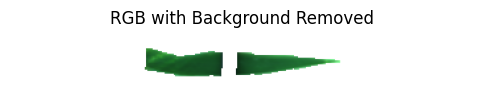

Cube shape: (204, 48, 352)


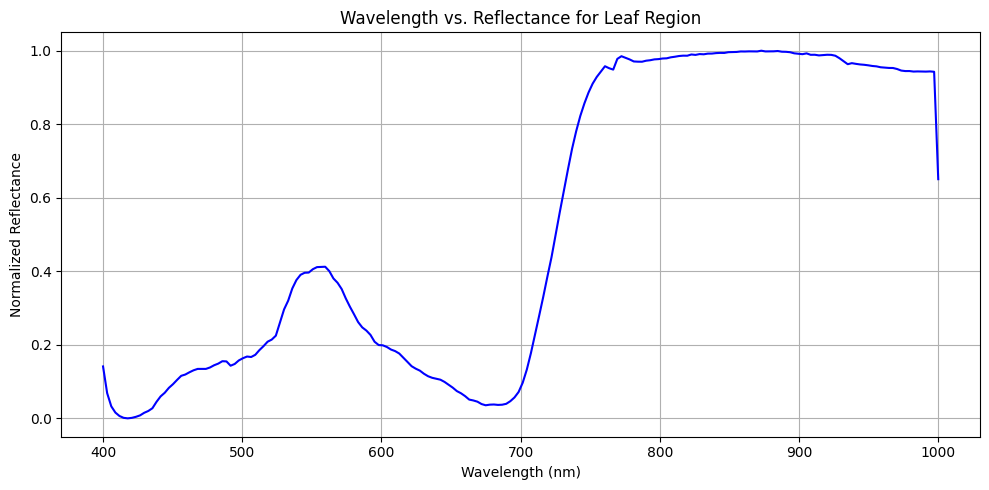

In [ ]:
import numpy as np
import tifffile as tiff

# Function to create a foreground mask using RGB bands
def create_foreground_mask(cube, rgb_bands=(88, 51, 24), threshold=0.05):
    """
    Creates a foreground mask using RGB bands.
    Pixels darker than `threshold` in all three channels are considered background.
    """
    # Take RGB bands from the cube
    r = cube[rgb_bands[0]]  # Red band
    g = cube[rgb_bands[1]]  # Green band
    b = cube[rgb_bands[2]]  # Blue band

    # Normalize each band
    def normalize(img):
        img = img.astype(np.float32)
        img -= img.min()
        img /= img.max() + 1e-8
        return img

    r = normalize(r)
    g = normalize(g)
    b = normalize(b)

    # Stack into RGB image
    rgb_img = np.stack([r, g, b], axis=-1)

    # Create background mask (where all RGB values are below threshold)
    background_mask = np.all(rgb_img <= threshold, axis=-1)

    # Invert to get foreground mask (True = leaf/pixel of interest)
    foreground_mask = ~background_mask

    return foreground_mask, rgb_img


# Main function to extract wavelength vs. reflectance
def extract_wavelength_reflectance(tiff_path, start_wavelength=400, end_wavelength=1000):
    """
    Extracts wavelength vs. reflectance for the leaf region in a hyperspectral TIFF file.

    Parameters:
    - tiff_path: Path to the hyperspectral TIFF file.
    - start_wavelength: Starting wavelength (in nm).
    - end_wavelength: Ending wavelength (in nm).

    Returns:
    - wavelengths: Array of wavelengths (in nm).
    - avg_spectrum: Normalized average reflectance spectrum for the leaf region.
    """
    # Load the hyperspectral cube
    cube = tiff.imread(tiff_path)
    print(f"Cube shape: {cube.shape}")

    # Estimate wavelengths
    num_bands = cube.shape[0]
    wavelengths = np.linspace(start_wavelength, end_wavelength, num_bands)

    # Create foreground mask
    foreground_mask, _ = create_foreground_mask(cube)

    # Get coordinates of leaf pixels
    ys, xs = np.where(foreground_mask)

    # Extract reflectance for all leaf pixels
    leaf_spectra = cube[:, ys, xs]  # Shape: (num_bands, num_leaf_pixels)

    # Average reflectance across all leaf pixels
    avg_spectrum = np.mean(leaf_spectra, axis=1)

    # Normalize the average spectrum
    avg_spectrum = (avg_spectrum - avg_spectrum.min()) / (avg_spectrum.max() - avg_spectrum.min() + 1e-8)

    return wavelengths, avg_spectrum















#@title Test Wavelength vs. Reflectance for Leaf Region
img_path = "/content/hyperleaf2024/images/00050.tiff"  # @param {type: "string"}
rgb_img = tiff_to_rgb_background_remove(img_path)

plt.figure(figsize=(6, 6))
plt.imshow(rgb_img)
plt.axis('off')
plt.title("RGB with Background Removed")
plt.show()


wavelengths, avg_spectrum = extract_wavelength_reflectance(img_path)

# Plot Wavelength vs. Reflectance
plt.figure(figsize=(10, 5))
plt.plot(wavelengths, avg_spectrum, color='blue')
plt.xlabel("Wavelength (nm)")
plt.ylabel("Normalized Reflectance")
plt.title("Wavelength vs. Reflectance for Leaf Region")
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
#@title Generate Spectral dataset
!wget https://raw.githubusercontent.com/p-p-p-p/precision-agriculture/refs/heads/main/dataset/wheat_spectral_dataset.csv
import os
import numpy as np
import pandas as pd
import tifffile as tiff
from tqdm import tqdm

# Define paths
img_dir = "/content/hyperleaf2024/images"


# Define the cultivar columns
cultivar_cols = ['Heerup', 'Kvium', 'Rembrandt', 'Sheriff']

# Create a copy of the DataFrame to preserve the original
temp_df = train_df.copy()

# Assign the cultivar name (column where value is 1) to new 'Class' column
temp_df['Class'] = temp_df[cultivar_cols].idxmax(axis=1)


# Assume temp_df already contains 'ImageId' and 'Class'
spectral_df = temp_df[['ImageId', 'Class']].copy()

# Estimate wavelength range
num_bands = 204  # Assuming 204 bands
wavelengths = np.linspace(400, 1000, num_bands)

# Create columns for each wavelength
for wl in wavelengths:
    spectral_df[f"{wl:.2f}"] = np.nan  # Use 2 decimal places as column names

# Reorder columns: metadata first, then spectral data
columns = ['ImageId', 'Class'] + [f"{wl:.2f}" for wl in wavelengths]
spectral_df = spectral_df[columns]

# Extract spectral data
for idx, row in tqdm(spectral_df.iterrows(), total=len(spectral_df)):
    img_id = row['ImageId']
    img_id=str(img_id).zfill(5)
    img_path = os.path.join(img_dir, f"{img_id}.tiff")

    if not os.path.exists(img_path):
        print(f"Missing: {img_path}")
        continue

    try:
        wl_array, reflectance = extract_wavelength_reflectance(img_path)

        # Ensure reflectance has correct number of bands
        if len(reflectance) != num_bands:
            print(f"Unexpected number of bands in {img_id}: {len(reflectance)}")
            continue

        # Update DataFrame row
        for i, wl in enumerate(wl_array):
            col_name = f"{wl:.2f}"
            if col_name in spectral_df.columns:
                spectral_df.at[idx, col_name] = reflectance[i]
            else:
                print(f"Warning: Column {col_name} not found in DataFrame for {img_id}")

    except Exception as e:
        print(f"Error processing {img_id}: {e}")
from IPython.display import clear_output
clear_output()
# Save to CSV
spectral_df.to_csv("wheat_spectral_dataset_colab.csv", index=False)
print("Saved as wheat_spectral_dataset_colab.csv")

🔍 Columns: <br>
ImageId: Identifier for each image (links to .tiff file)<br>
Regression targets : GrainWeight, Gsw, PhiPS2, Fertilizer<br>
Classification target (one-hot encoded) : Heerup, Kvium, Rembrandt, <br>Sheriff

In [ ]:
# hyperleaf2024
# |-- images
# |   |-- 000000.tiff
# |   |-- 000001.tiff
# |   |-- ...........
# |   |-- ...........
# |   |-- 002410.tiff
# |-- test.csv
# |-- sample_submission.csv
# |-- train.csv


In [ ]:
# import os

# def display_folder_structure(start_path, indent=""):
#     for item in os.listdir(start_path):
#         path = os.path.join(start_path, item)
#         if os.path.isdir(path):
#             print(indent + "📁 " + item)
#             display_folder_structure(path, indent + "    ")
#         else:
#             if ".tiff" in item:
#               pass
#             else:
#               print(indent + "📄 " + item)

# # Example: Replace with the folder path you want to explore
# folder_path = "/content/hyperleaf2024"  # Current directory
# display_folder_structure(folder_path)
